In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Cambria', 'Times New Roman']})

import seaborn as sns

In [2]:
%load_ext watermark

In [3]:
%watermark -h -v -m -p pandas,numpy,matplotlib

CPython 3.6.0
IPython 5.1.0

pandas 0.19.2
numpy 1.11.3
matplotlib 2.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : user-PC


In [4]:
pd.options.display.max_rows = 15

In [5]:
h5root = '..\\h5 files\\'
chartdir = 'C:\\Users\\user\\Documents\\Agent-Based Models\\Charts\\'

In [6]:
h5subdir = 'Trial 113\\'
h5file = 'smallcap_%d.h5' % 4

In [7]:
h5in = '%s%s%s' % (h5root, h5subdir, h5file)

In [8]:
trade_df = pd.read_hdf(h5in, 'trades')
trade_df = trade_df.assign(trader_id = trade_df.resting_order_id.str.split('_').str[0])
lt_df = pd.DataFrame(trade_df.groupby(['trader_id']).quantity.count())
lt_df.rename(columns={'quantity': 'trade'}, inplace=True)
if 'p999999' in lt_df.index:
    lt_df.drop('p999999', inplace=True)
ltsum_df = pd.DataFrame(trade_df.groupby(['trader_id']).quantity.sum())
ltsum_df.rename(columns={'quantity': 'trade_vol'}, inplace=True)
if 'p999999' in ltsum_df.index:
    ltsum_df.drop('p999999', inplace=True)
#lt_df,
ltsum_df

,trade_vol
trader_id,
m0,21279
p0,24
p1,5
p10,4
p11,1
p12,5
p13,70
...,...
p43,4


In [11]:
trade_df.groupby(['side', 'trader_id']).quantity.sum().to_csv('testbuysandsells.csv')

### Participation Rates - by trade count and trade volume

In [64]:
lt_df = lt_df.assign(Participation = 100*lt_df.trade/lt_df.trade.sum())
ltsum_df = ltsum_df.assign(Participation = 100*ltsum_df.trade_vol/ltsum_df.trade_vol.sum())
lt_df, ltsum_df

(            trade  Participation
 trader_id                       
 m0         103673      93.585427
 p0             67       0.060481
 p1             36       0.032497
 p10            71       0.064092
 p11            47       0.042427
 p12           239       0.215745
 p13           155       0.139918
 ...           ...            ...
 p43            18       0.016249
 p44            56       0.050551
 p5            141       0.127280
 p6            132       0.119156
 p7             42       0.037913
 p8             70       0.063189
 p9           1597       1.441609
 
 [46 rows x 2 columns],            trade_vol  Participation
 trader_id                          
 m0            103673      93.585427
 p0                67       0.060481
 p1                36       0.032497
 p10               71       0.064092
 p11               47       0.042427
 p12              239       0.215745
 p13              155       0.139918
 ...              ...            ...
 p43               18      

In [65]:
for j in ltsum_df.index[:6]:
    print('%.2f' % ltsum_df.loc[j,'Participation'])

93.59
0.06
0.03
0.06
0.04
0.22


In [66]:
ltsum_df = ltsum_df.assign(ProviderClass = ltsum_df.index.str[0])
ltsum_df.groupby('ProviderClass').Participation.describe()

ProviderClass       
m              count     1.000000
               mean     93.585427
               std            NaN
               min      93.585427
               25%      93.585427
               50%      93.585427
               75%      93.585427
                          ...    
p              mean      0.142546
               std       0.224357
               min       0.009027
               25%       0.039719
               50%       0.083048
               75%       0.139918
               max       1.441609
Name: Participation, dtype: float64

### Profitability

In [67]:
mmcf_df = pd.read_hdf(h5in, 'mmp')
mmcf_df

,cash_flow,mmid,position,timestamp
0,1001600,m0,-1,14
1,2003200,m0,-2,16
2,3004800,m0,-3,17
3,2003215,m0,-2,18
4,1001630,m0,-1,19
5,2003230,m0,-2,20
6,1001645,m0,-1,21
...,...,...,...,...
103666,533190550,m0,-531,99995
103667,532188955,m0,-530,99996


In [68]:
corr_df = mmcf_df.groupby(['timestamp', 'mmid'])['position'].last()
corr_df = corr_df.unstack('mmid')
corr_df = corr_df.reindex(index=pd.Index(range(0,100001)))
corr_df.fillna(method='ffill', inplace=True)
corr_df.index.rename('timestamp', inplace=True)
corrs = corr_df.corr()[corr_df.corr() < 1]
corrs

mmid,m0
mmid,
m0,NaN


In [69]:
outcorr = pd.Series(corrs.stack().unique())
for j  in [outcorr.mean(), outcorr.std(), outcorr.min(),outcorr.quantile(0.25), 
           outcorr.median(), outcorr.quantile(0.755), outcorr.max()]:
    print('%.2f' % j)

nan
nan
nan
nan
nan
nan
nan


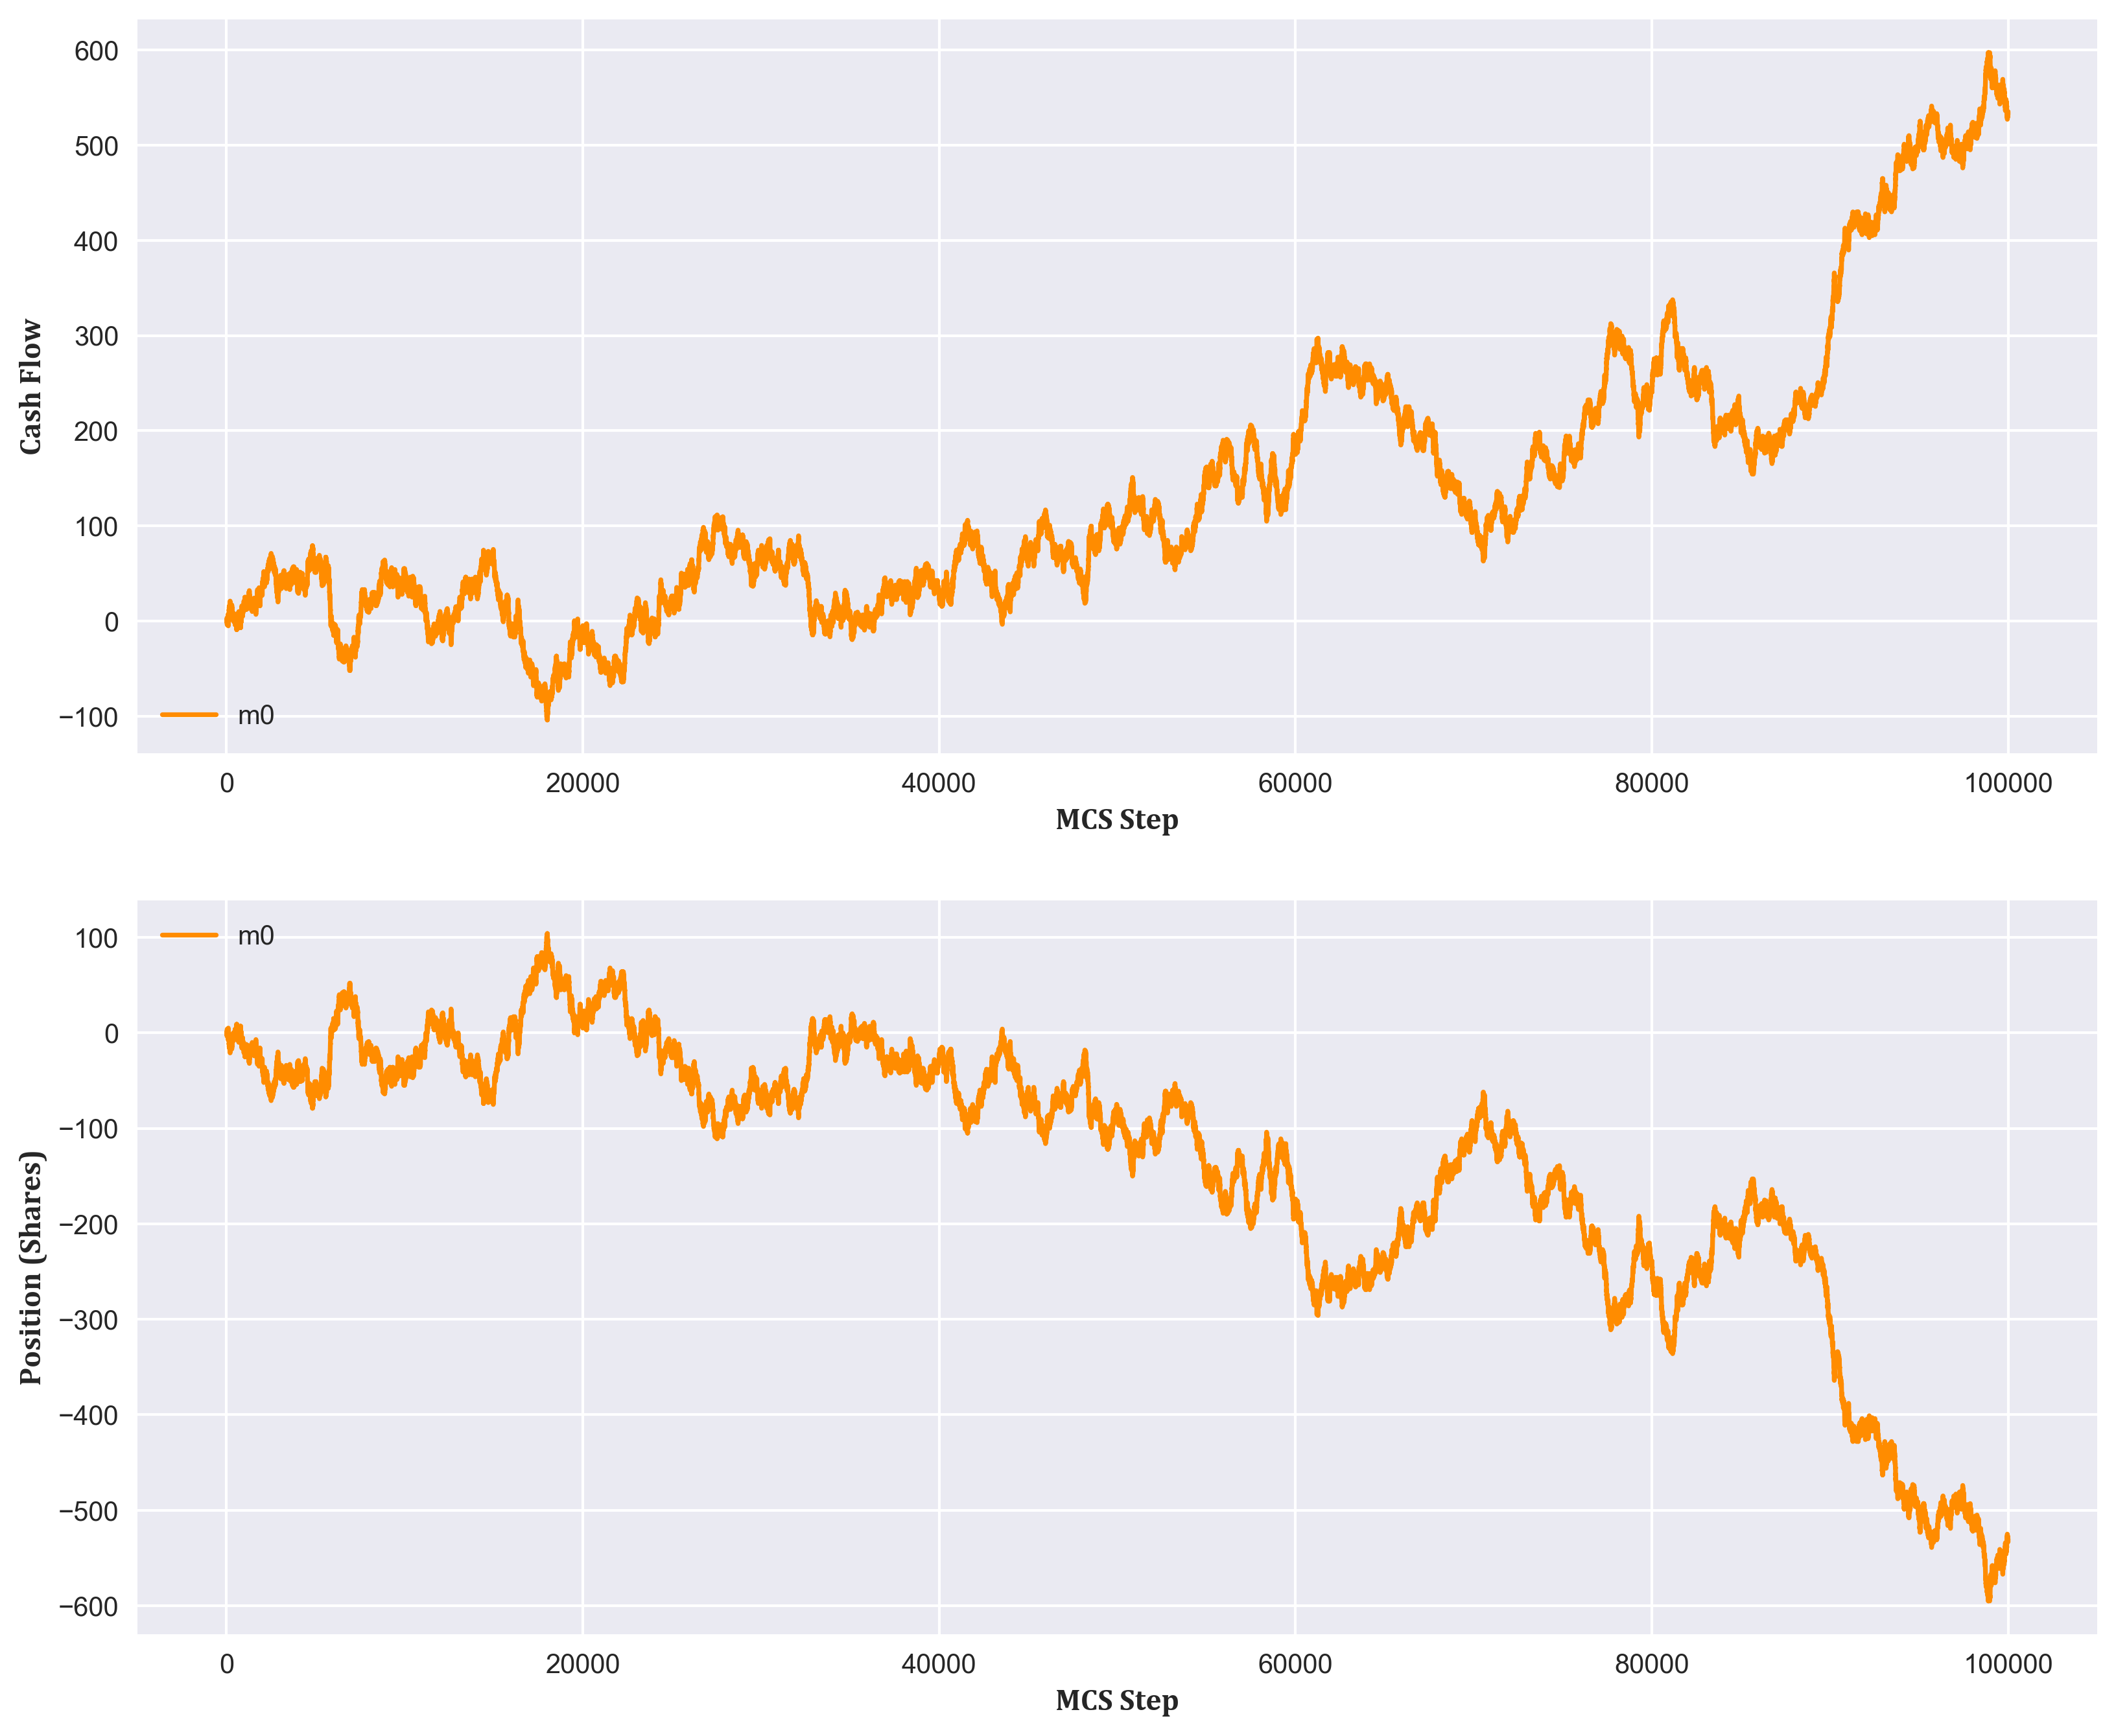

In [70]:
colors=['DarkOrange', 'DarkBlue', 'DarkGreen', 'DarkRed', 'Chartreuse']
fig = plt.figure(figsize=(13,11), dpi=300, facecolor='w')
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for c, mm in enumerate(mmcf_df.mmid.unique()):
    temp_df = mmcf_df[mmcf_df.mmid==mm]
    temp_df = temp_df.groupby('timestamp')['cash_flow', 'position'].last()
    temp_df = temp_df.reindex(index=pd.Index(np.arange(start=0, stop=100001, step=1)))
    temp_df.fillna(method='ffill', inplace=True)
    temp_df.index.rename('timestamp', inplace=True)
    ax1.plot(temp_df.cash_flow/1000000, linestyle='solid', color=colors[c], marker='None', label=mm)
    ax2.plot(temp_df.position, linestyle='solid', color=colors[c], marker='None', label=mm)
ax1.set_xlabel('MCS Step', family='Cambria')
ax1.set_ylabel('Cash Flow', family='Cambria')
ax1.legend(loc='lower left')
ax2.set_xlabel('MCS Step', family='Cambria')
ax2.set_ylabel('Position (Shares)', family='Cambria')
ax2.legend(loc='upper left')
fig.savefig('%sposition.png' % chartdir)
plt.show()

In [71]:
final_positions = mmcf_df.groupby('mmid')['position', 'cash_flow'].last()
mark_to_market = trade_df[trade_df.timestamp==100000].price.mean()
#final_positions = final_positions.assign(MarkToMarketCF = final_positions.cash_flow + final_positions.position*mark_to_market)
#final_positions = final_positions.assign(CFPerTrade = final_positions.MarkToMarketCF/lt_df.trade,
#                                         CFPerShare = final_positions.MarkToMarketCF/ltsum_df.trade_vol
#                                        )
#for m in final_positions.index:
#    print('%.f3' % (final_positions.loc[m,'MarkToMarketCF']))
final_positions, mark_to_market

(      position  cash_flow
 mmid                     
 m0        -533  535193920, 1001640.0)

### Cash Flow

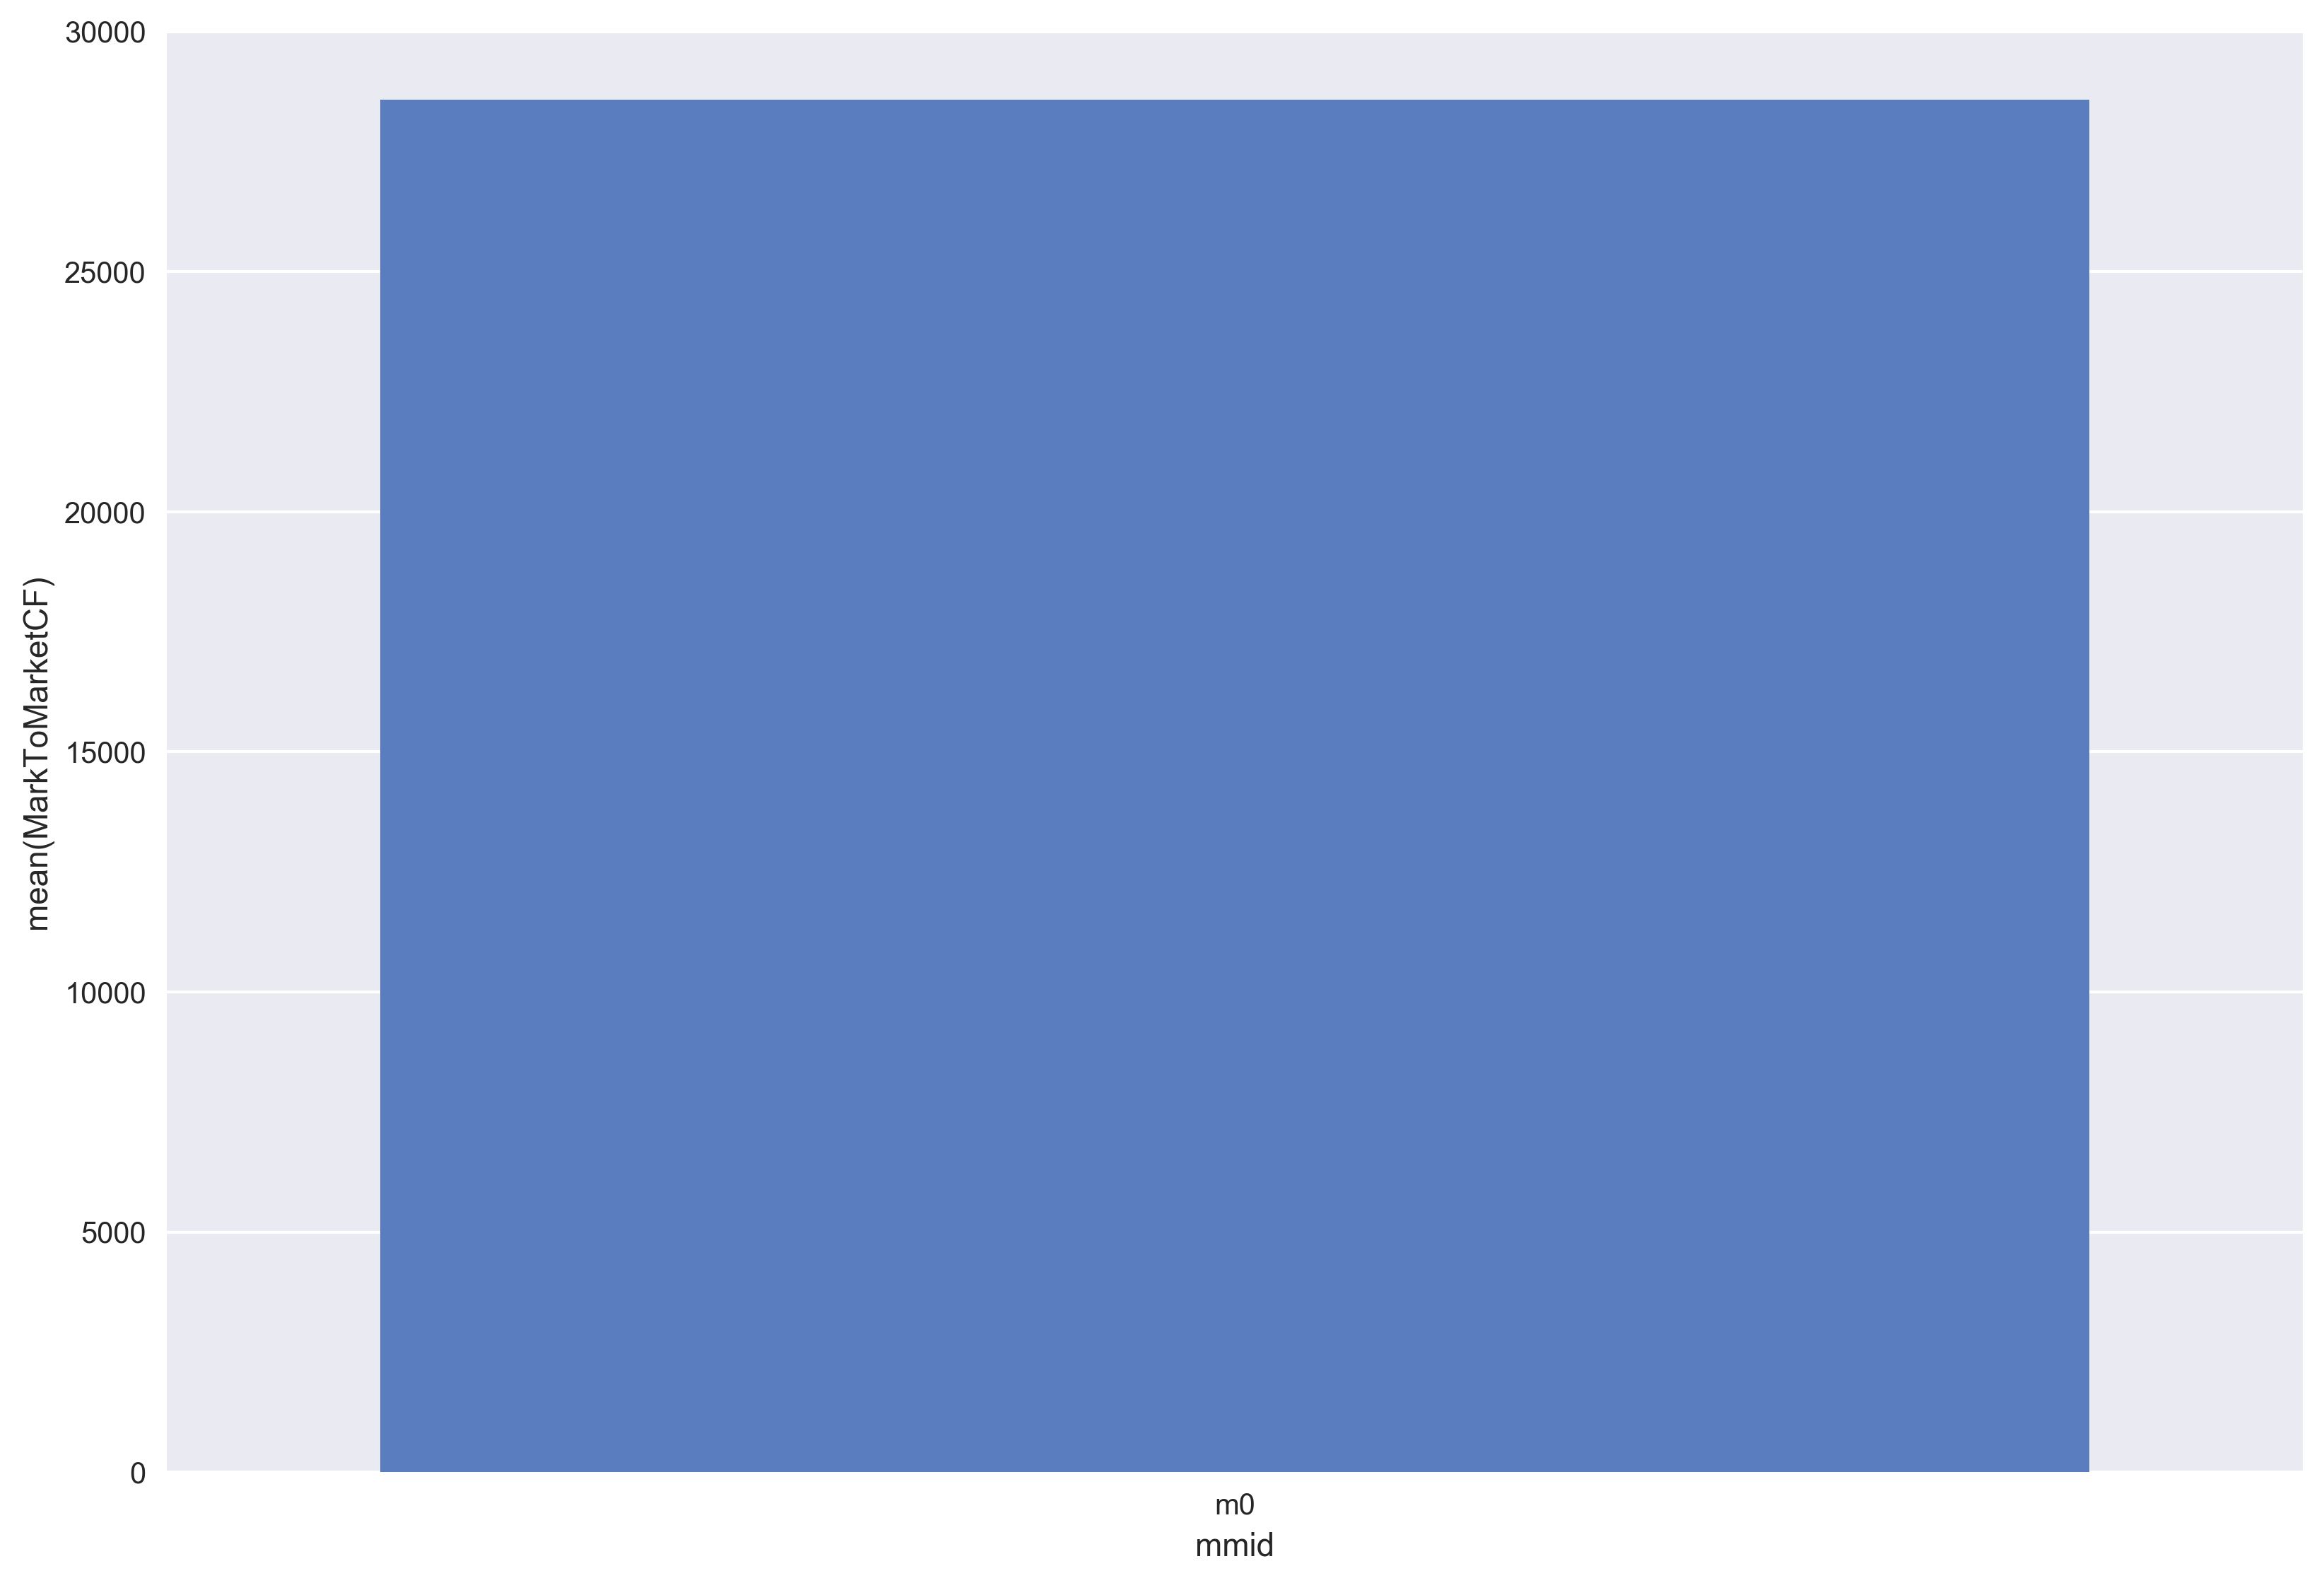

In [17]:
fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(111)
sns.barplot(x=final_positions.index, y=final_positions.MarkToMarketCF, ax=ax1, palette="muted")
plt.show()

### Cash Flow Per Trade

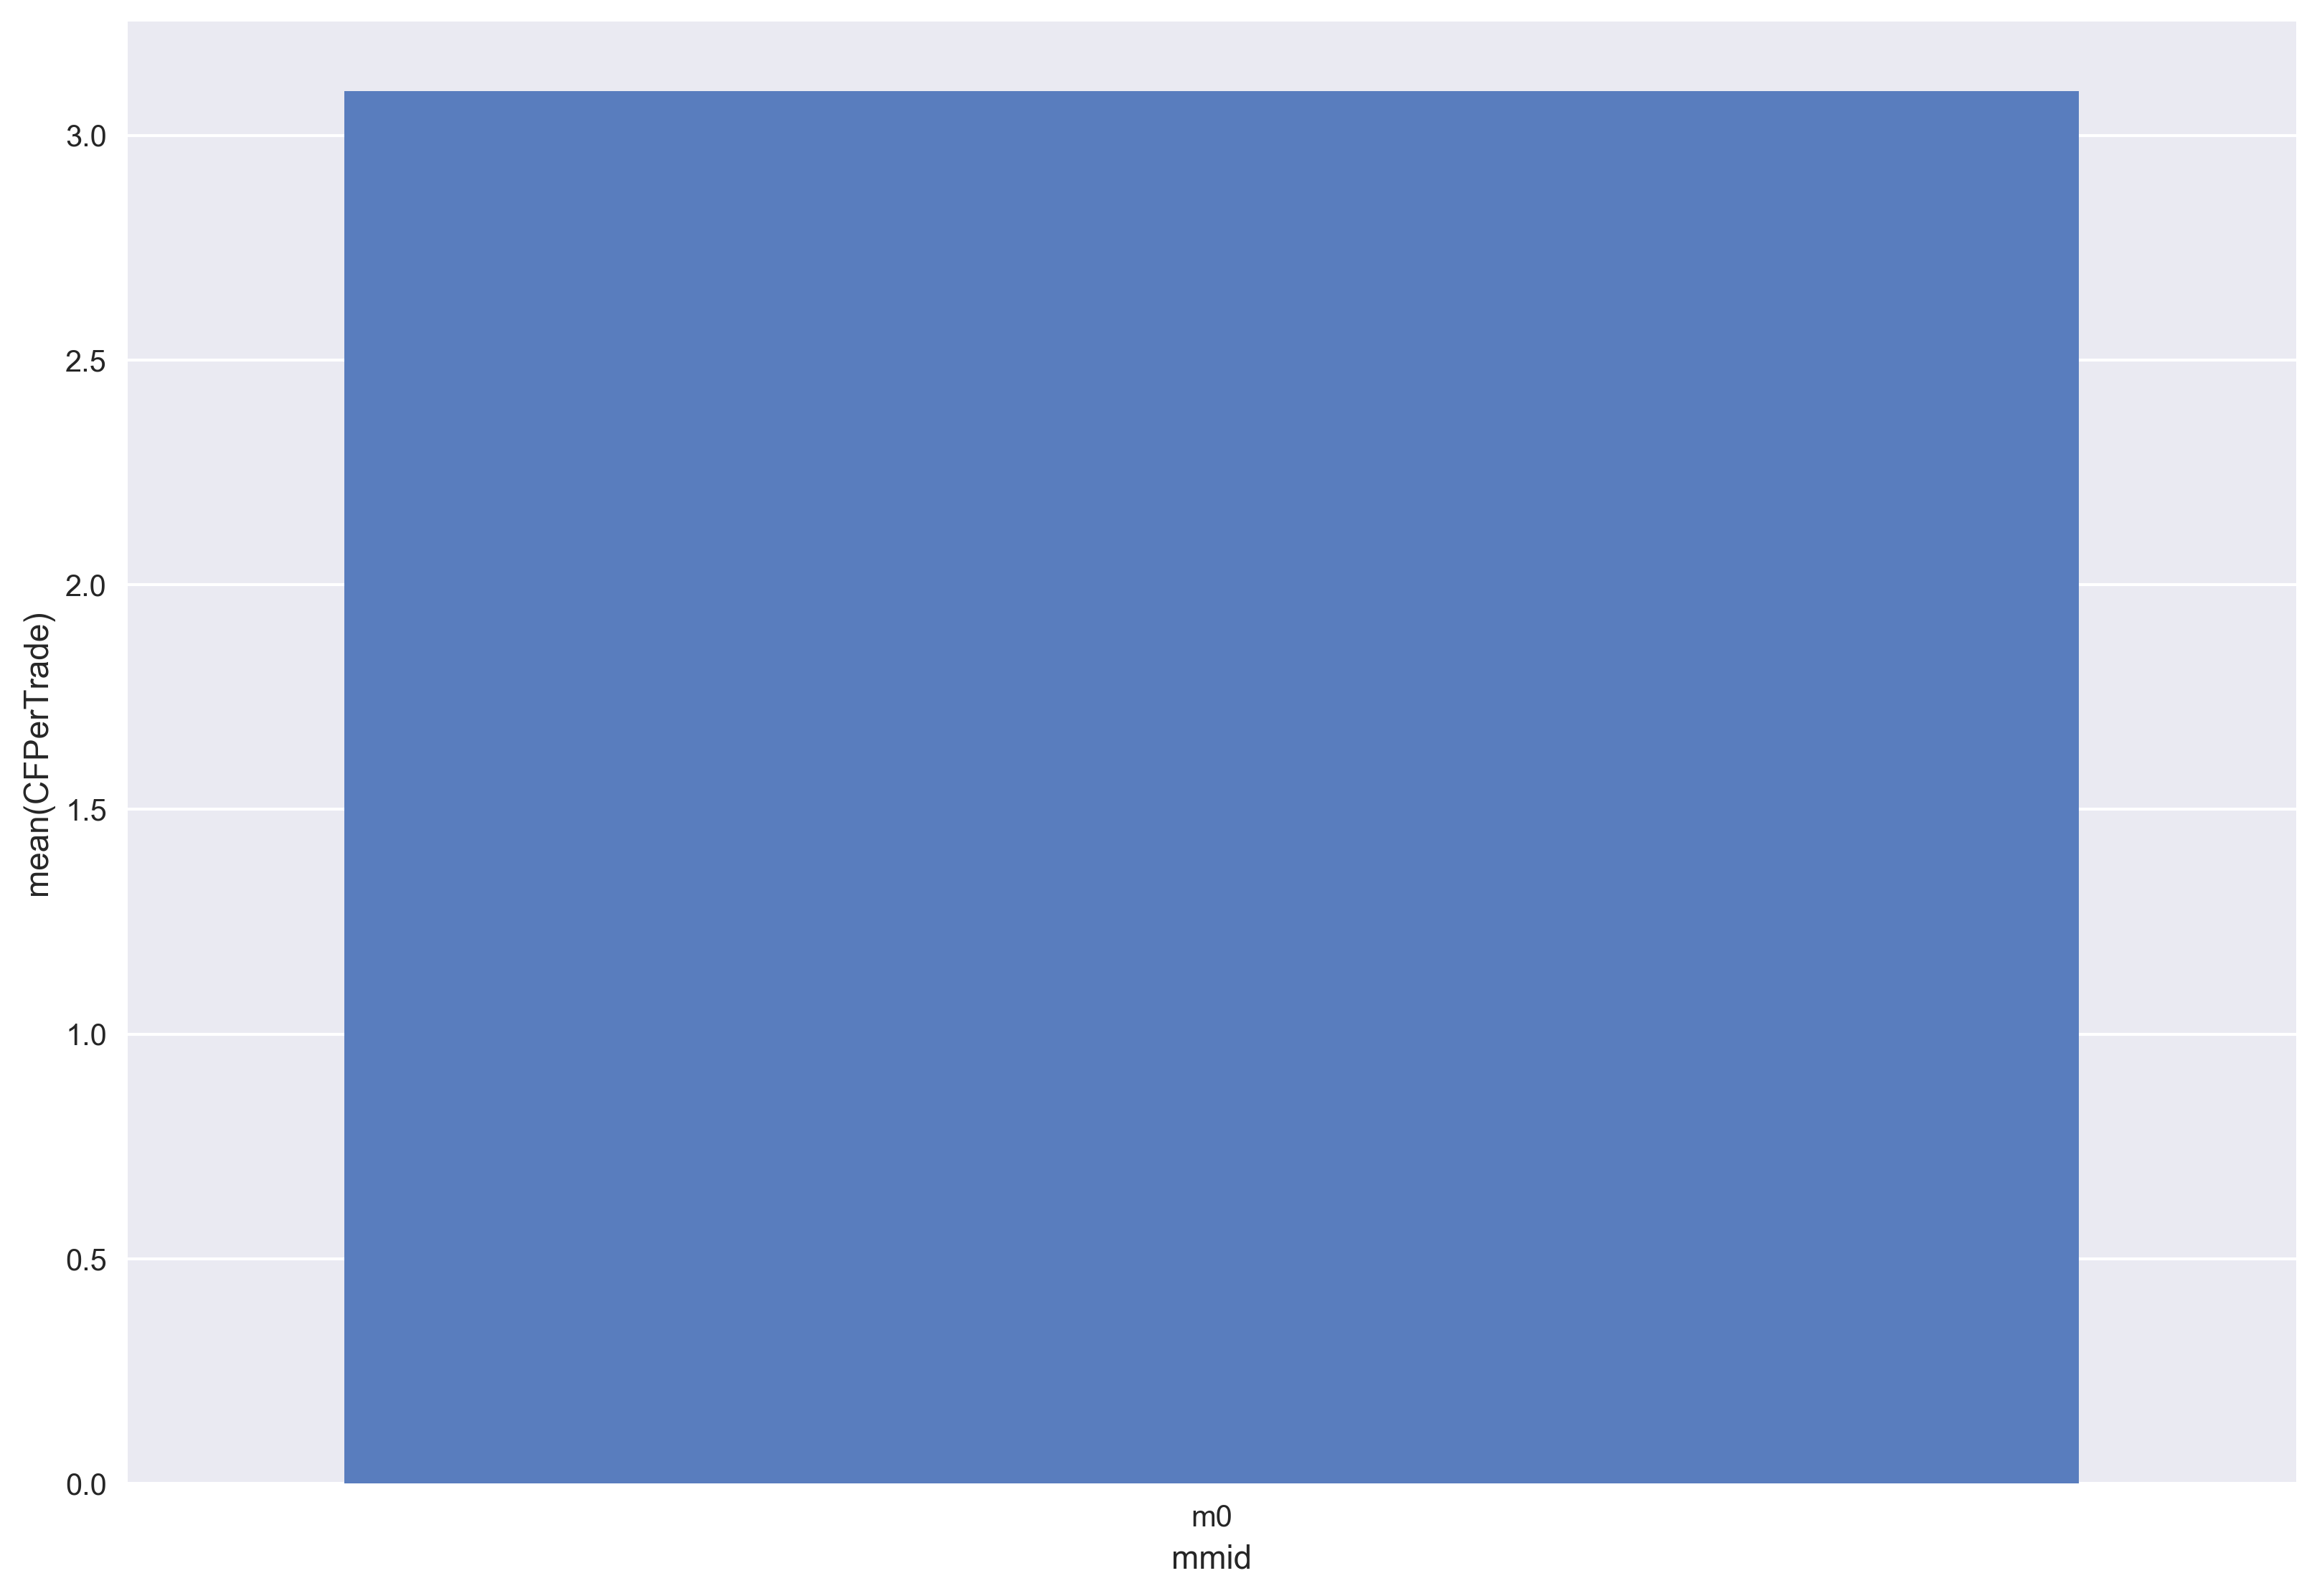

In [18]:
fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(111)
sns.barplot(x=final_positions.index, y=final_positions.CFPerTrade, ax=ax1, palette="muted")
plt.show()

### Cash Flow Per Share

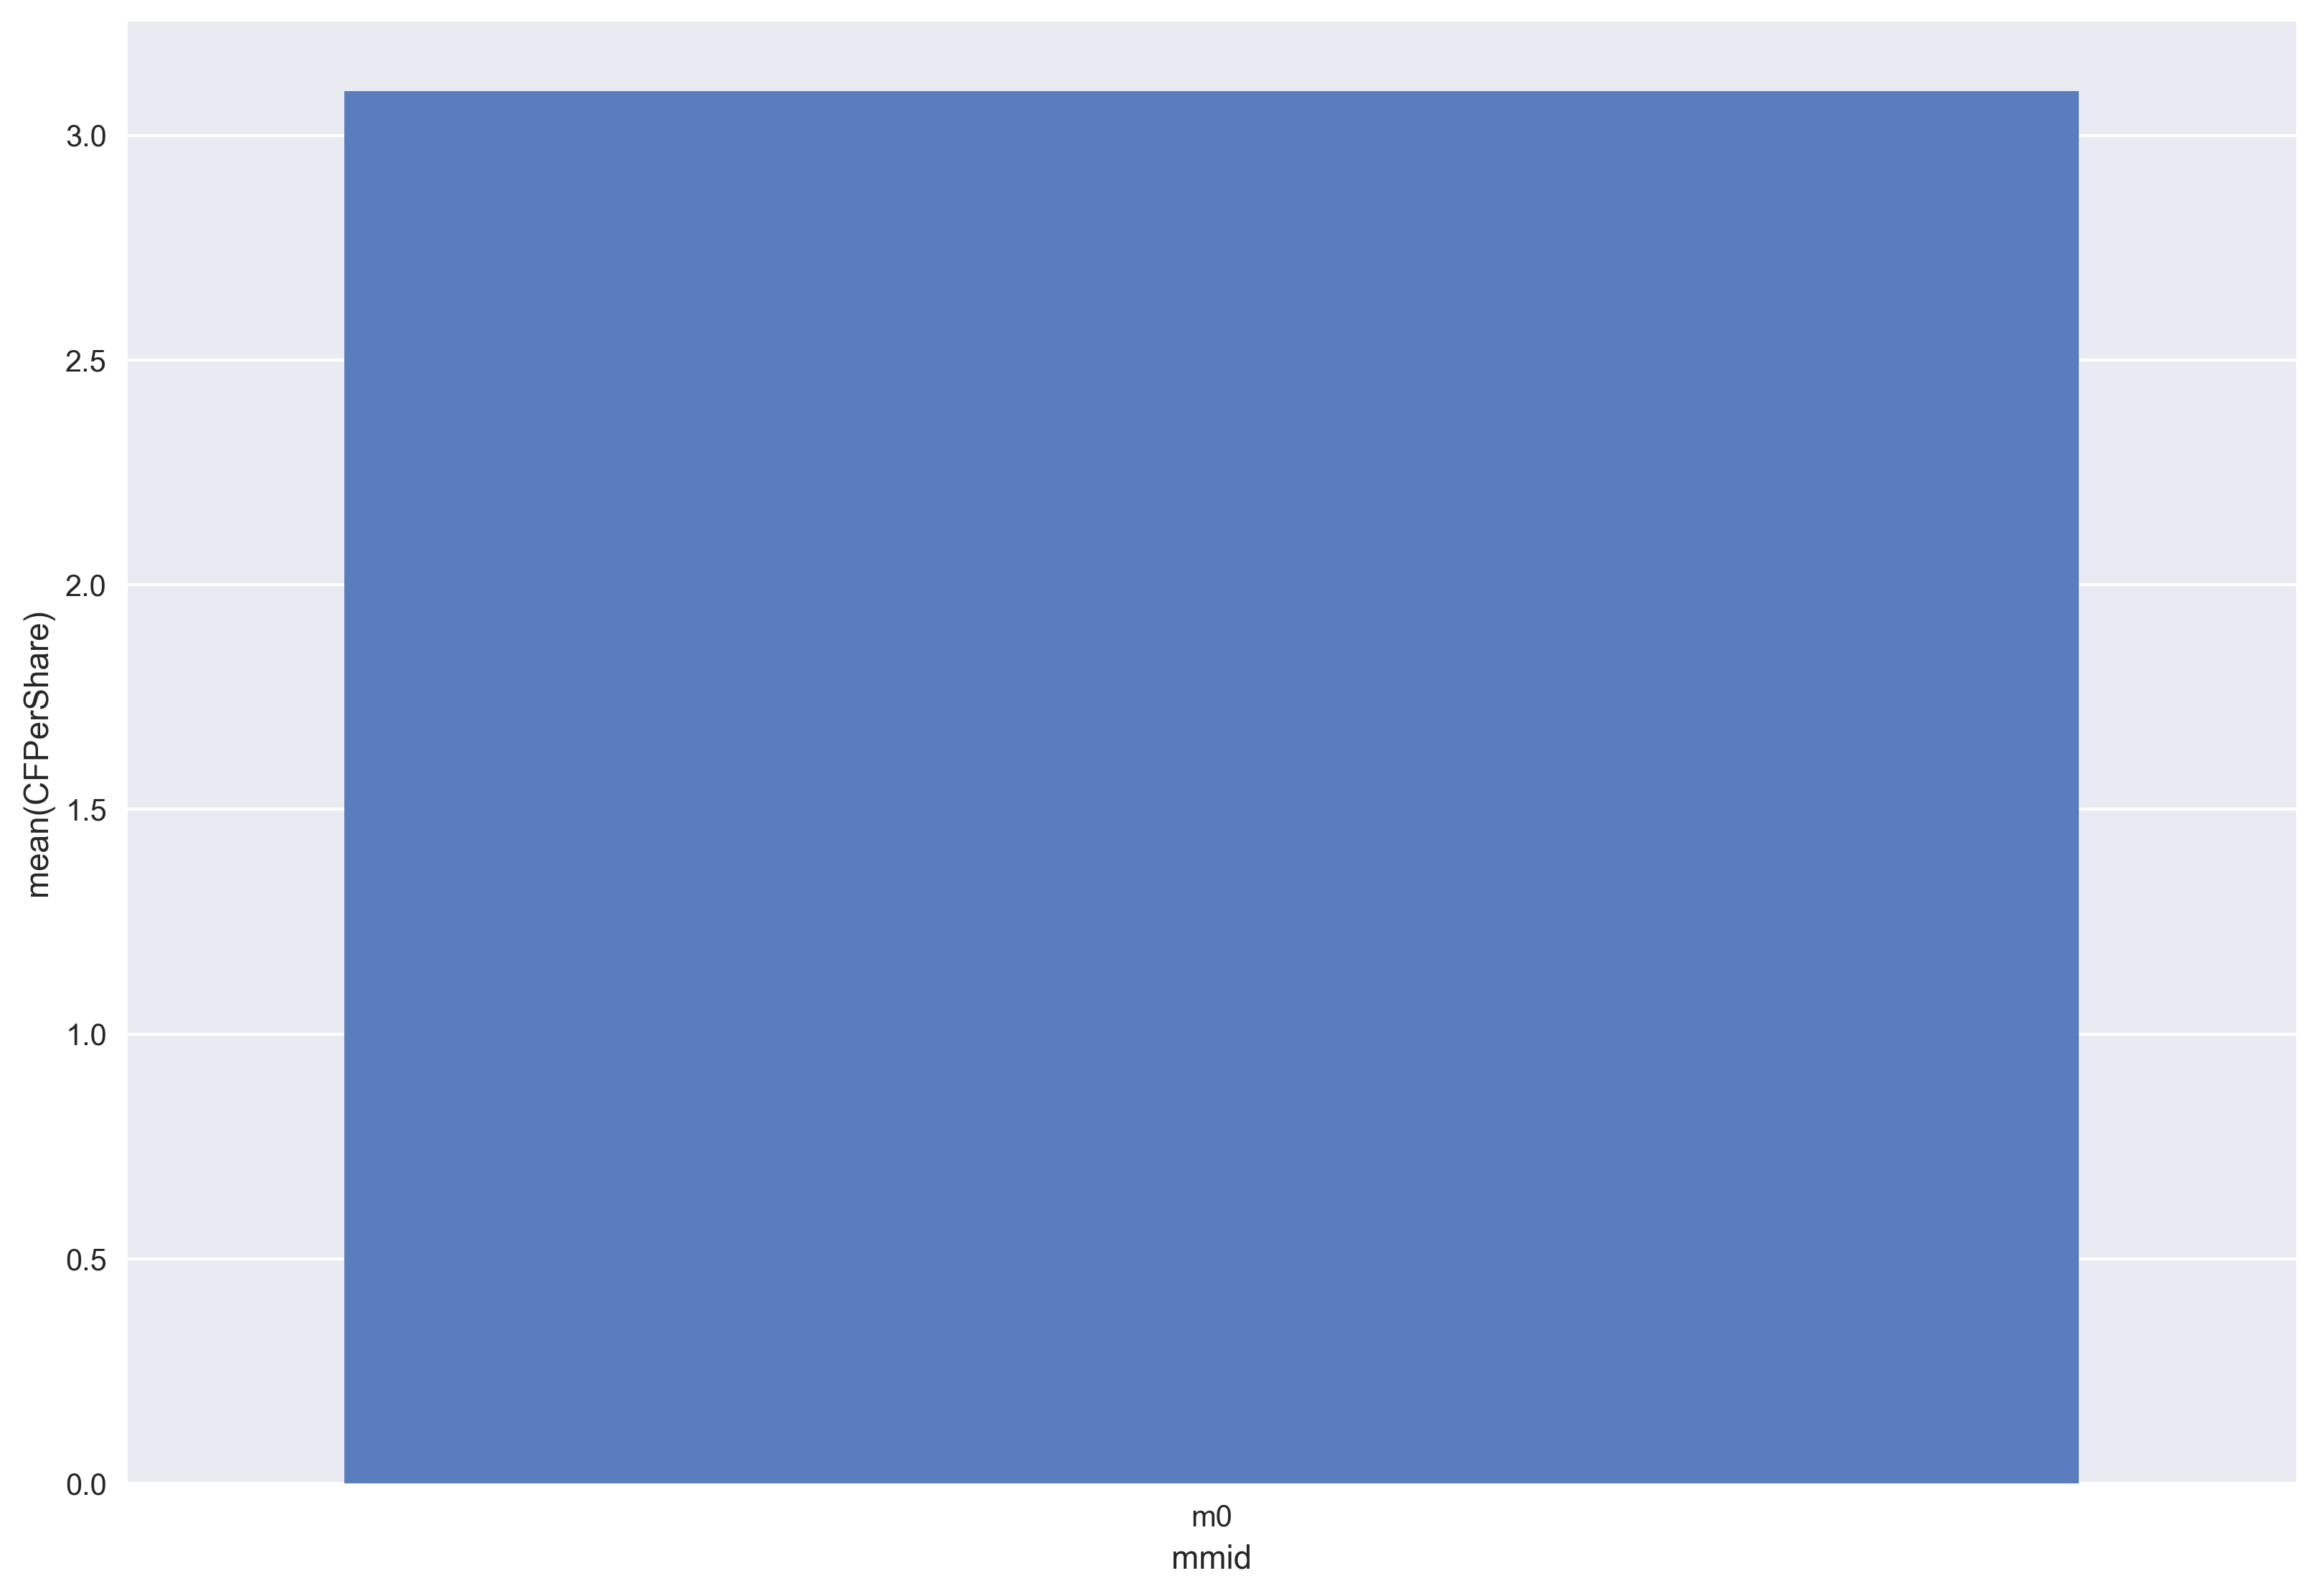

In [19]:
fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(111)
sns.barplot(x=final_positions.index, y=final_positions.CFPerShare, ax=ax1, palette="muted")
plt.show()

### Volume-Matched Cash Flow

In [20]:
trade_df

,incoming_order_id,price,quantity,resting_order_id,resting_timestamp,side,timestamp,trader_id
0,t40_1,1000330,1,p0_2,2,sell,25,p0
1,t40_2,1000335,1,p0_10,10,buy,50,p0
2,t40_3,1000330,1,m0_38,24,sell,75,m0
3,t40_4,1000335,1,m0_94,46,buy,100,m0
4,t6_1,1000335,1,m0_136,64,buy,103,m0
5,t40_5,1000330,1,m0_61,34,sell,125,m0
6,t40_6,1000335,1,m0_148,68,buy,150,m0
...,...,...,...,...,...,...,...,...
9852,t28_183,1000380,1,m0_249653,99870,sell,99918,m0
9853,t31_117,1000385,1,m0_249699,99888,buy,99918,m0


In [21]:
buy_trades = trade_df[trade_df.side=='buy']
buy_trades = buy_trades.assign(BuyCashFlow = buy_trades.price*buy_trades.quantity)
buy_trades = buy_trades.assign(BuyVol = buy_trades.groupby('trader_id').quantity.cumsum(),
                               CumulBuyCF = buy_trades.groupby('trader_id').BuyCashFlow.cumsum()
                              )
buy_trades.rename(columns={'timestamp': 'buytimestamp'}, inplace=True)
sell_trades = trade_df[trade_df.side=='sell']
sell_trades = sell_trades.assign(SellCashFlow = -sell_trades.price*sell_trades.quantity)
sell_trades = sell_trades.assign(SellVol = sell_trades.groupby('trader_id').quantity.cumsum(),
                                 CumulSellCF = sell_trades.groupby('trader_id').SellCashFlow.cumsum()
                                )
sell_trades.rename(columns={'timestamp': 'selltimestamp'}, inplace=True)
buy_trades = buy_trades[['trader_id', 'BuyVol', 'CumulBuyCF', 'buytimestamp']]
sell_trades = sell_trades[['trader_id', 'SellVol', 'CumulSellCF', 'selltimestamp']]
buy_trades, sell_trades

(     trader_id  BuyVol  CumulBuyCF  buytimestamp
 1           p0       1     1000335            50
 3           m0       1     1000335           100
 4           m0       2     2000670           103
 6           m0       3     3001005           150
 8           m0       4     4001340           181
 9           m0       5     5001675           200
 11          m0       6     6002010           206
 ...        ...     ...         ...           ...
 9845        m0    4619  4620579745         99875
 9846        m0    4620  4621580130         99876
 9847        m0    4621  4622580515         99900
 9850        m0    4622  4623580900         99912
 9851        m0    4623  4624581285         99918
 9853        m0    4624  4625581670         99918
 9856        m0    4625  4626582055         99975
 
 [4916 rows x 4 columns],      trader_id  SellVol  CumulSellCF  selltimestamp
 0           p0        1     -1000330             25
 2           m0        1     -1000330             75
 5           m

In [22]:
cash_flow = pd.merge(buy_trades, sell_trades, left_on=['trader_id', 'BuyVol'], right_on=['trader_id', 'SellVol'])
cash_flow = cash_flow.assign(NetCashFlow = cash_flow.CumulBuyCF + cash_flow.CumulSellCF,
                             MaxTime = np.where(cash_flow.buytimestamp>cash_flow.selltimestamp, cash_flow.buytimestamp,
                                                cash_flow.selltimestamp)
                            )
cash_flow

,trader_id,BuyVol,CumulBuyCF,buytimestamp,SellVol,CumulSellCF,selltimestamp,MaxTime,NetCashFlow
0,p0,1,1000335,50,1,-1000330,25,50,5
1,m0,1,1000335,100,1,-1000330,75,100,5
2,m0,2,2000670,103,2,-2000660,125,125,10
3,m0,3,3001005,150,3,-3000990,175,175,15
4,m0,4,4001340,181,4,-4001320,203,203,20
5,m0,5,5001675,200,5,-5001650,225,225,25
6,m0,6,6002010,206,6,-6001980,250,250,30
...,...,...,...,...,...,...,...,...,...
4849,m0,4595,4596570505,99294,4595,-4596542070,99905,99905,28435
4850,m0,4596,4597570890,99300,4596,-4597542450,99910,99910,28440


In [23]:
traders = cash_flow.trader_id.unique()
market_makers = [x for x in traders if x.startswith('m')]
market_makers

['m0']

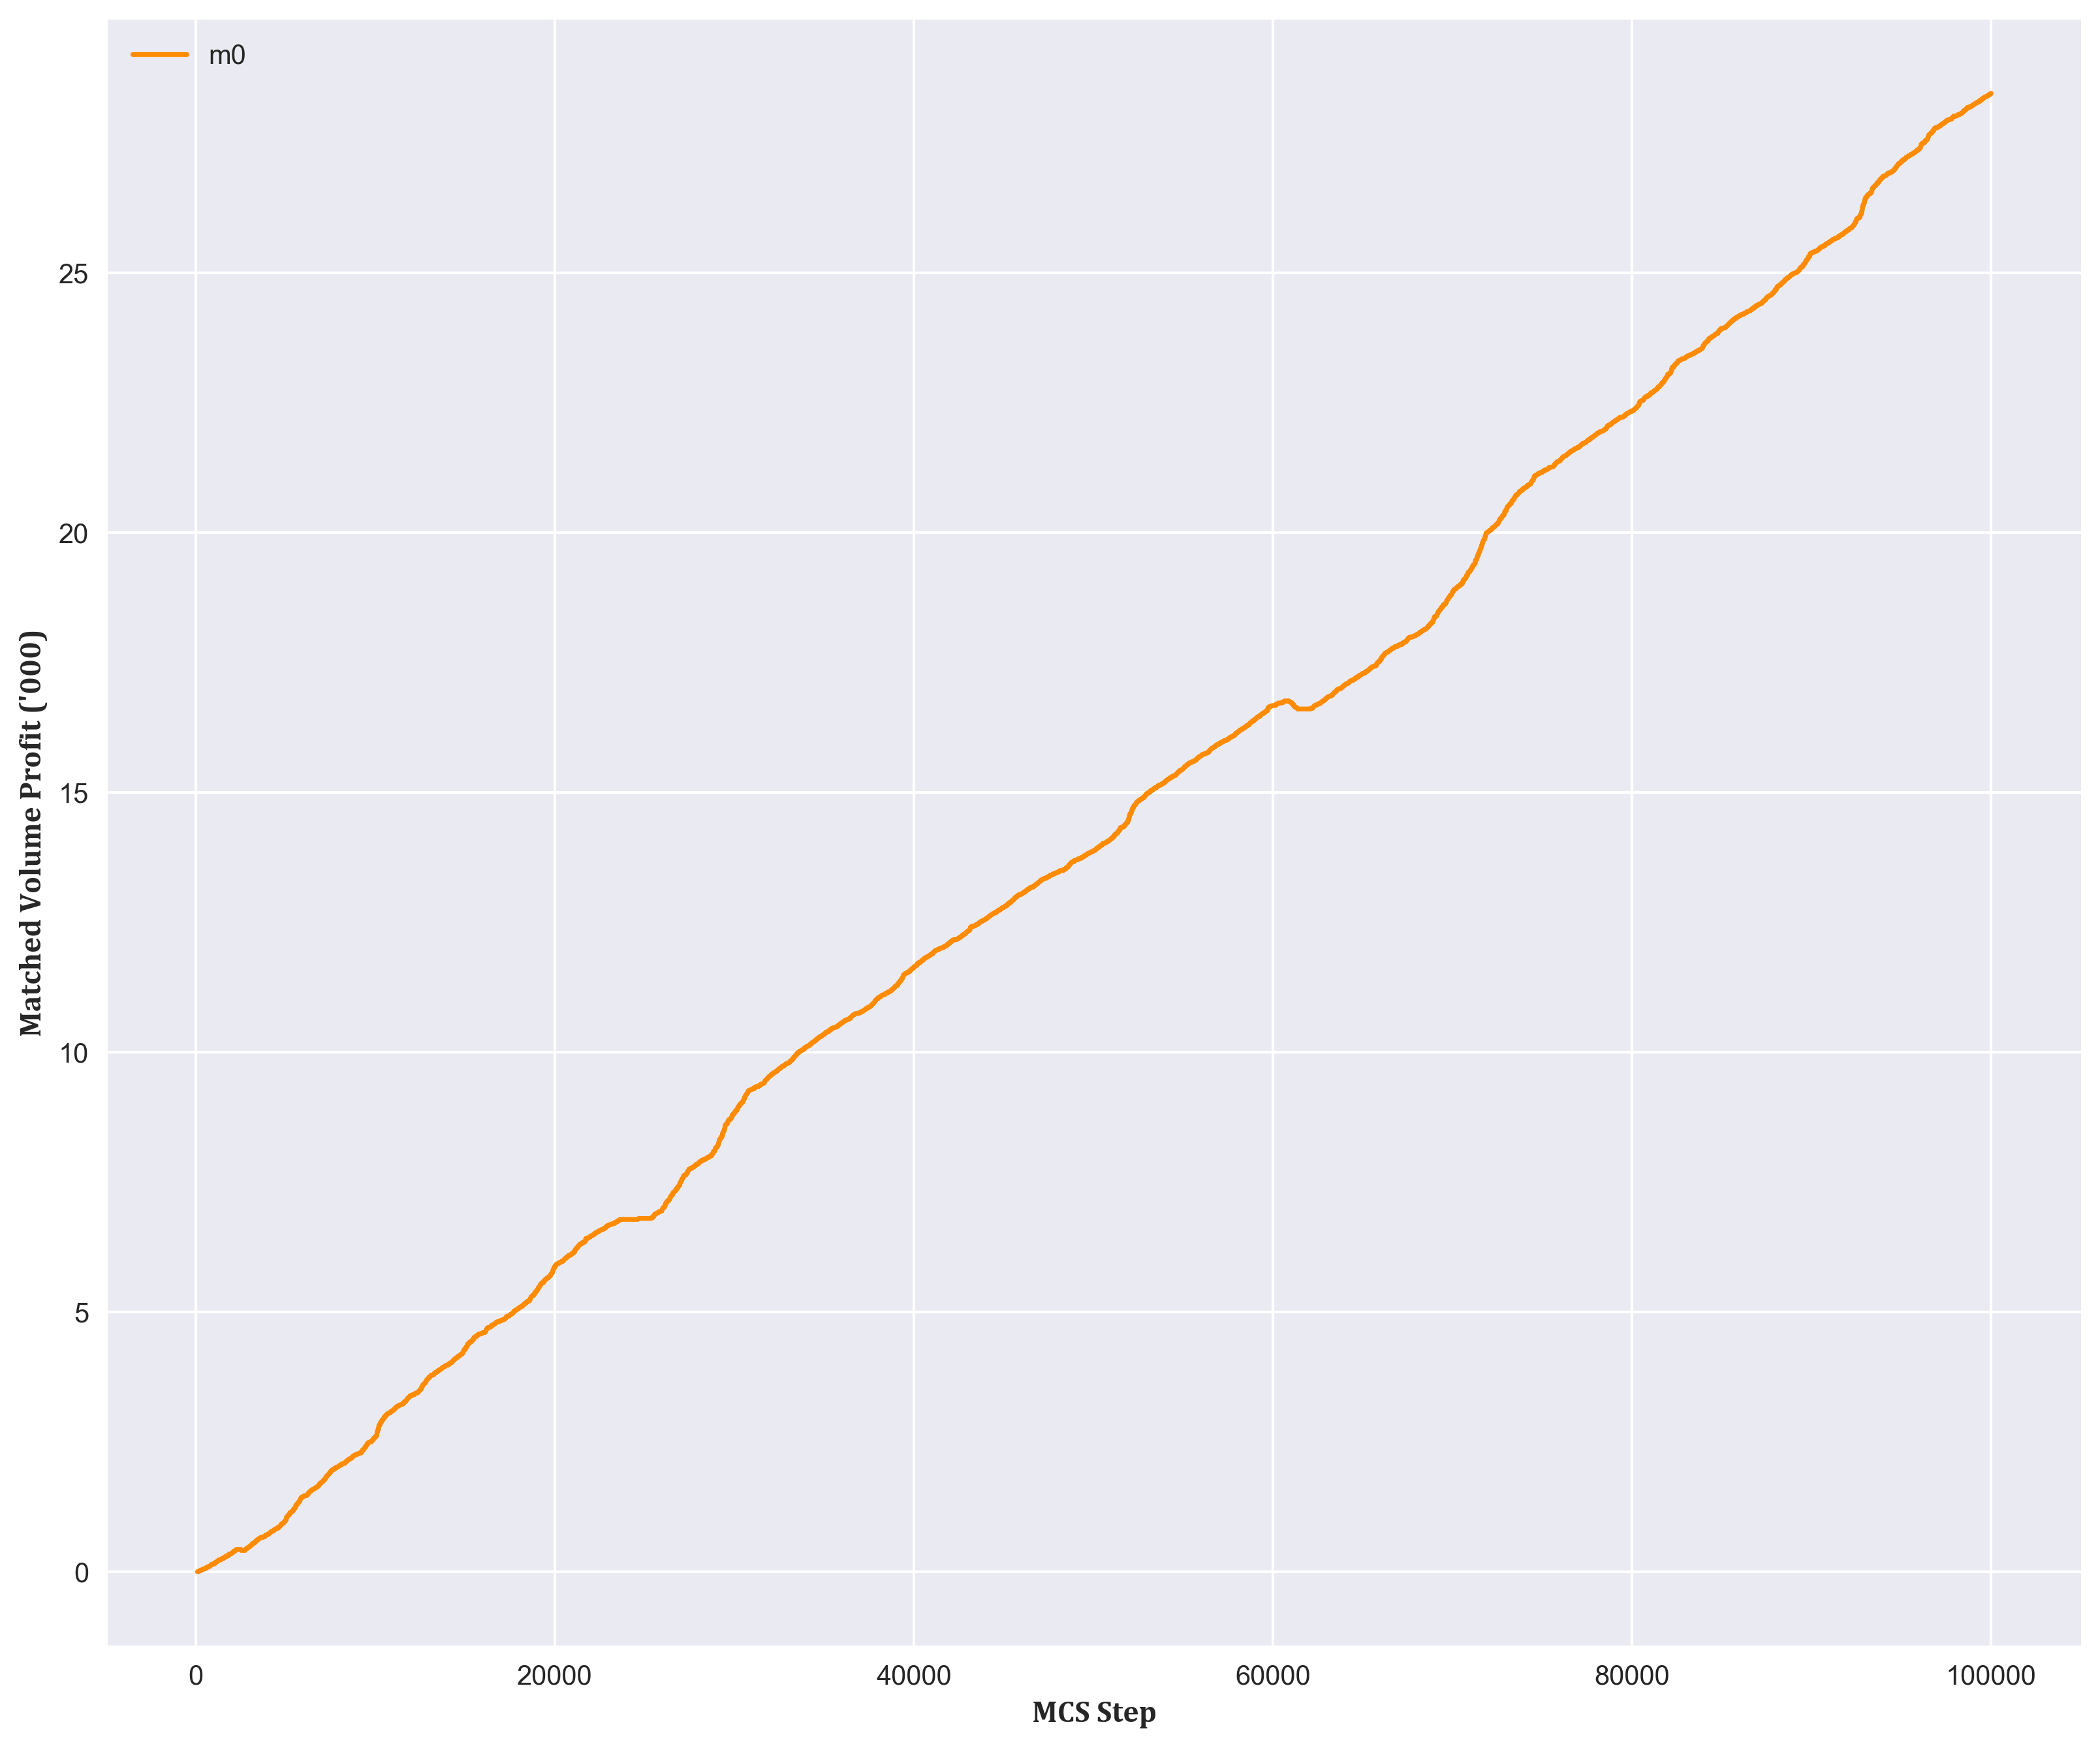

In [24]:
colors=['DarkOrange', 'DarkBlue', 'DarkGreen', 'DarkRed', 'Chartreuse']
fig = plt.figure(figsize=(13,11), dpi=300, facecolor='w')
ax1 = fig.add_subplot(111)
for c, mm in enumerate(market_makers):
    temp_df = cash_flow[cash_flow.trader_id==mm]
    temp_df = temp_df.groupby('MaxTime').NetCashFlow.last()
    temp_df = temp_df.reindex(index=pd.Index(np.arange(start=0, stop=100001, step=1)))
    temp_df.fillna(method='ffill', inplace=True)
    temp_df.index.rename('timestamp', inplace=True)
    ax1.plot(temp_df/1000, linestyle='solid', color=colors[c], marker='None', label=mm)
ax1.set_xlabel('MCS Step', family='Cambria')
ax1.set_ylabel("Matched Volume Profit ('000)", family='Cambria')
ax1.legend(loc='upper left')
fig.savefig('%scashflow2.png' % chartdir)
plt.show()

In [25]:
final_positions.index

Index(['m0', 'm1', 'm2', 'm3', 'm4'], dtype='object', name='mmid')

In [37]:
import random

In [73]:
random.uniform(0,1)

0.8146175891702957

In [74]:
np.random.uniform(0,1)

0.8363418362880183

In [90]:
min_ask_price = 105
p = np.random.choice(range(min_ask_price, min_ask_price+16, 5), 100)
p

array([110, 115, 110, 115, 120, 105, 105, 110, 120, 115, 115, 105, 110,
       115, 115, 120, 110, 115, 110, 105, 115, 115, 115, 115, 110, 115,
       120, 105, 115, 120, 120, 120, 105, 120, 115, 110, 105, 105, 110,
       110, 110, 110, 105, 105, 105, 120, 105, 120, 115, 120, 115, 115,
       115, 105, 105, 105, 105, 110, 120, 120, 105, 105, 105, 115, 110,
       105, 105, 105, 105, 110, 115, 105, 110, 120, 120, 115, 120, 110,
       105, 115, 110, 110, 110, 105, 105, 120, 115, 115, 105, 110, 115,
       110, 105, 105, 115, 115, 120, 110, 105, 115])